# Effect of Polls on Donations

In [103]:
import os
import sys
import json
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from nltk.metrics import *
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Simple Linear Regression
Amount raised in one week -> polling percentage in morning consult weekly poll

In [53]:
polls = pd.read_csv(os.path.join("..","data","polls","president_primary_polls.csv"))
results = polls.loc[polls["cycle"]==2020]
results = results.loc[results["stage"]=="primary"]
results = results.loc[results["party"]=="DEM"]
results = results.loc[results["pollster"]=="Morning Consult"]
results = results.groupby(by=["candidate_name","created_at"])["pct"].mean()
results = results.unstack(level="candidate_name")
results.head()

candidate_name,Amy Klobuchar,Andrew Cuomo,Andrew Yang,Bernard Sanders,Beto O'Rourke,Bill de Blasio,Cory A. Booker,Deval Patrick,Elizabeth Warren,Eric Garcetti,...,Michael Avenatti,Michael Bloomberg,Michael F. Bennet,Pete Buttigieg,Seth Moulton,Sherrod Brown,Steve Bullock,Terry R. McAuliffe,Tim Ryan,Tulsi Gabbard
created_at,,,,,,,,,,,,,,,,,,,,,
1/16/19 08:16,1.0,NaN,NaN,15.0,8.0,NaN,2.0,NaN,9.0,0.0,...,NaN,1.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN
1/23/19 08:15,2.0,NaN,NaN,16.0,6.0,NaN,4.0,NaN,6.0,0.0,...,NaN,2.0,NaN,NaN,NaN,1.0,1.0,0.0,NaN,1.0
1/29/19 23:17,1.0,NaN,NaN,15.0,6.0,NaN,3.0,NaN,6.0,0.0,...,NaN,2.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0
1/9/19 13:53,2.0,0.0,NaN,16.0,7.0,NaN,3.0,NaN,4.0,0.0,...,NaN,1.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN
12/27/18 03:57,1.0,1.0,NaN,19.0,8.0,NaN,3.0,0.0,5.0,1.0,...,0.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN


In [6]:
# find the path to each fec file, store paths in a nested dict
fec_2020_paths = {}
base_path = os.path.join("..","data","fec","2020")
for party_dir in os.listdir(base_path):
    if(party_dir[0]!="."):
        fec_2020_paths[party_dir] = {}
        for cand_dir in os.listdir(os.path.join(base_path,party_dir)):
            if(cand_dir[0]!="."):
                fec_2020_paths[party_dir][cand_dir] = {}
                for csv_path in os.listdir(os.path.join(base_path,party_dir,cand_dir)):
                    if(csv_path.find("schedule_a")>=0):
                        fec_2020_paths[party_dir][cand_dir]["donations"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
                    elif(csv_path.find("schedule_b")>=0):
                        fec_2020_paths[party_dir][cand_dir]["spending"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
print(json.dumps(fec_2020_paths, indent=4))

{
    "republican": {
        "trump": {
            "spending": "../data/fec/2020/republican/trump/schedule_b-2019-05-30T16_03_37.csv",
            "donations": "../data/fec/2020/republican/trump/schedule_a-2019-05-30T16_03_37.csv"
        }
    },
    "democrat": {
        "williamson": {
            "spending": "../data/fec/2020/democrat/williamson/schedule_b-2019-05-30T20_41_44.csv",
            "donations": "../data/fec/2020/democrat/williamson/schedule_a-2019-05-30T20_41_32.csv"
        },
        "harris": {
            "spending": "../data/fec/2020/democrat/harris/schedule_b-2019-05-30T17_22_09.csv",
            "donations": "../data/fec/2020/democrat/harris/schedule_a-2019-05-30T17_19_58.csv"
        },
        "buttigieg": {
            "donations": "../data/fec/2020/democrat/buttigieg/schedule_a-2019-05-30T17_32_11.csv",
            "spending": "../data/fec/2020/democrat/buttigieg/schedule_b-2019-05-30T17_32_14.csv"
        },
        "klobuchar": {
            "spending": "

Map candidates names from donations to polls
If you adopt this for another dataset, you'll just need to adjust line 4.

In [33]:
name_mapping = {}
poll_names = results.columns
for candid in fec_2020_paths["democrat"].keys():
    comparison_scores = [edit_distance(x[-len(candid):].lower(), candid.lower()) for x in poll_names]
    val, idx = min((val, idx) for (idx, val) in enumerate(comparison_scores))
    name_mapping[candid] = poll_names[idx]
    print("{:s} -> {:s} (score: {:d})".format(candid, name_mapping[candid], val))

williamson -> Marianne Williamson (score: 0)
harris -> Kamala D. Harris (score: 0)
buttigieg -> Pete Buttigieg (score: 0)
klobuchar -> Amy Klobuchar (score: 0)
yang -> Andrew Yang (score: 0)
gillibrand -> Kirsten E. Gillibrand (score: 0)
delaney -> John K. Delaney (score: 0)
inslee -> Jay Robert Inslee (score: 0)
hickenlooper -> John Hickenlooper (score: 0)
orourke -> Beto O'Rourke (score: 1)
warren -> Elizabeth Warren (score: 0)
castro -> Julián Castro (score: 0)
sanders -> Bernard Sanders (score: 0)
gabbard -> Tulsi Gabbard (score: 0)
booker -> Cory A. Booker (score: 0)


In [96]:
dataset = pd.DataFrame()
for candid in fec_2020_paths["democrat"].keys():
    if("donations" in fec_2020_paths["democrat"][candid].keys()):
        
        # process donations dataset
        df = pd.read_csv(fec_2020_paths["democrat"][candid]["donations"])
        df["contribution_receipt_date"] = pd.to_datetime(df["contribution_receipt_date"]).dt.date
        df = df.loc[df["entity_type"]=="IND"]
        df = df.loc[df["contribution_receipt_amount"]<=2800]
        df = df.groupby(by="contribution_receipt_date")["contribution_receipt_amount"].sum()
        df.name = "individual_donations"
        df = pd.DataFrame(df)
        df["candidate"] = candid
        
        #  process polling dataset
        candid_polls = results[name_mapping[candid]]
        candid_polls.name = "polling_percentage"
        candid_polls.index = pd.to_datetime(candid_polls.index).date
        df = df.join(candid_polls, how="left")
        df["polling_percentage"] = df["polling_percentage"].interpolate(limit_direction='both').fillna(0.0)
        df = df.rename_axis("date").reset_index()
        
        # append to main df
        dataset = dataset.append(df)

In [146]:
X_train = dataset["polling_percentage"].reshape(-1, 1)
y_train = dataset["individual_donations"]
X_test = np.array(range(0,36)).reshape(-1, 1)
linear_fit = LinearRegression().fit(X_train, y_train)
y_pred = linear_fit.predict(X_test)

Text(0.5,1,'Predicting Donations with Polling Percentage')

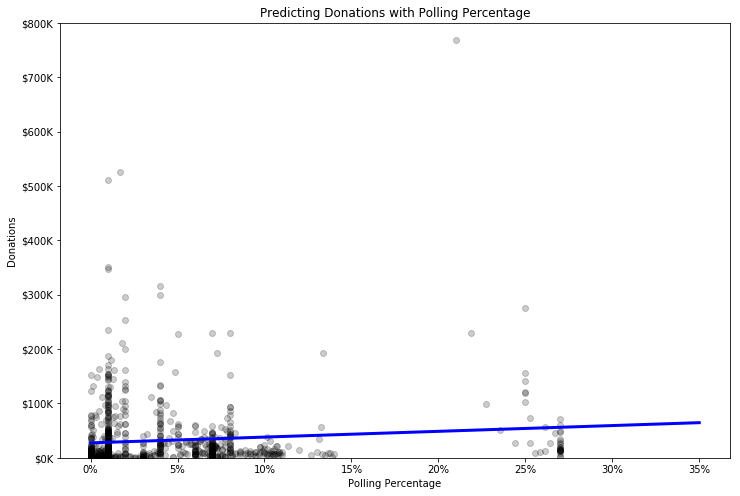

In [148]:
fix, ax = plt.subplots(figsize=(12,8))
plot_scale = (10**3,"K","Thousands")
plt.scatter(X_train, y_train/plot_scale[0],  color='black', alpha=0.2)
plt.plot(X_test, y_pred/plot_scale[0], color='blue', linewidth=3)
plt.ylim(0,800)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("$%0.0f{:s}".format(plot_scale[1])))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f%%"))
plt.ylabel("Donations")
plt.xlabel("Polling Percentage")
plt.title("Predicting Donations with Polling Percentage")